In [1]:
# -------------------------
# Optional installs (uncomment if needed)
# -------------------------
!pip install torch==2.1.2 torchvision==0.16.2
!pip install transformers==4.36.2 pandas numpy scikit-learn pillow tqdm seaborn matplotlib

/Users/mehshidatiq/Documents/POST_BILKENT/RESEARCH/EMOTIC_ensemble/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mehshidatiq/Documents/POST_BILKENT/RESEARCH/EMOTIC_ensemble/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[INFO] Using device: mps
[INFO] Loading image processor (google/vit-base-patch16-224)...
[INFO] Loading test annotations...
[INFO] Building ViT and loading weights...


/Users/mehshidatiq/Documents/POST_BILKENT/RESEARCH/EMOTIC_ensemble/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([26]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([26, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Loaded weights from: runs/vit_emotic_20250819-192210/best_vit_emotic.pth
[INFO] Loaded thresholds from runs/vit_emotic_20250819-192210/thresholds.npy with shape (26,)
[INFO] Evaluating on test set...


Testing ViT: 100%|██████████| 228/228 [03:04<00:00,  1.24it/s]



VIT EVALUATION SUMMARY
mAP:       0.1732
Mean C-F1: 0.1879
O-F1:      0.1230

Detailed Per-Category Metrics:
      Emotion  ViT_AP  ViT_F1
    Affection  0.1448  0.2065
        Anger  0.1398  0.2026
    Annoyance  0.1457  0.2241
 Anticipation  0.4938  0.4763
     Aversion  0.7735  0.0000
   Confidence  0.5564  0.5209
  Disapproval  0.4812  0.3772
Disconnection  0.2987  0.3414
 Disquietment  0.5354  0.4803
        Doubt  0.0587  0.0897
Embarrassment  0.0800  0.1295
   Engagement  0.1326  0.1952
       Esteem  0.1261  0.1529
   Excitement  0.0544  0.0887
      Fatigue  0.0157  0.0000
         Fear  0.0612  0.1007
    Happiness  0.0397  0.0579
         Pain  0.0271  0.0385
        Peace  0.0383  0.0620
     Pleasure  0.0228  0.0399
      Sadness  0.0269  0.0000
  Sensitivity  0.0462  0.0733
    Suffering  0.1239  0.1881
     Surprise  0.0310  0.0462
     Sympathy  0.0208  0.0000
     Yearning  0.0293  0.0431

[INFO] Saved: per_category_results_vit.csv
[INFO] Generating visualizations...


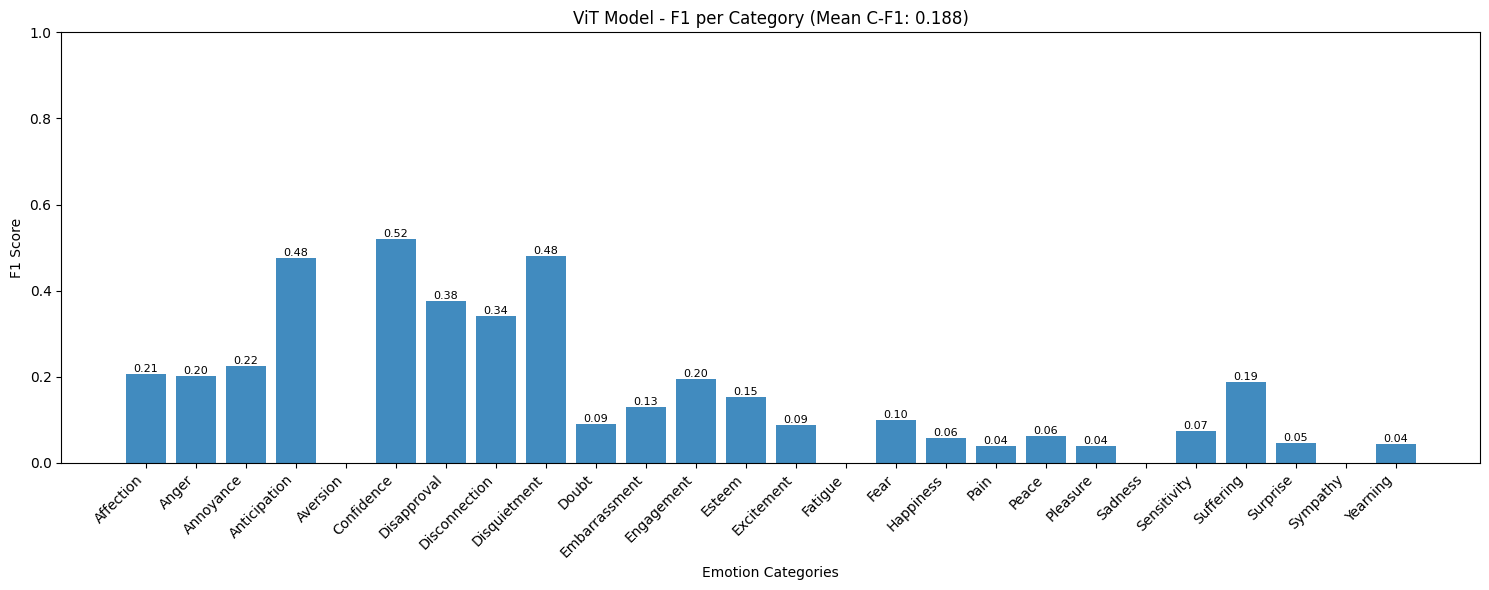

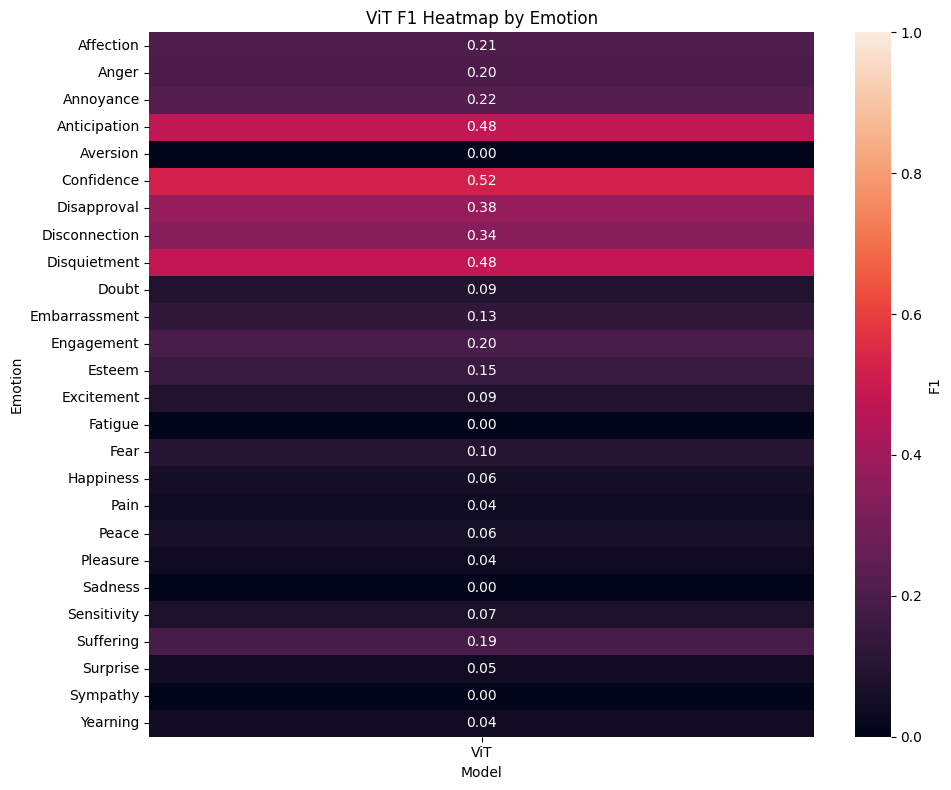


Top 5 ViT categories by F1:
  Confidence: 0.5209
  Disquietment: 0.4803
  Anticipation: 0.4763
  Disapproval: 0.3772
  Disconnection: 0.3414

Bottom 5 ViT categories by F1:
  Aversion: 0.0000
  Fatigue: 0.0000
  Sadness: 0.0000
  Sympathy: 0.0000
  Pain: 0.0385


In [2]:

"""
ViT EMOTIC — Testing & Evaluation (Fixed)

This notebook evaluates a trained ViT multi‑label classifier on EMOTIC-style
CSV annotations and NumPy image arrays.

Expected layout (adjust paths below if yours differ):
- archive/annots_arrs/annot_arrs_train.csv
- archive/annots_arrs/annot_arrs_val.csv
- archive/annots_arrs/annot_arrs_test.csv
- archive/img_arrs/<*.npy>                     # RGB or grayscale arrays
- runs/<run-id>/best_vit_emotic.pth            # saved model weights
- runs/<run-id>/thresholds.npy                 # optional per-class thresholds

What this notebook does:
1) Loads your annotations and .npy images
2) Builds the ViT model head exactly like during training
3) Loads weights from best_vit_emotic.pth
4) Loads dynamic thresholds if present, otherwise computes from val, else uses 0.5
5) Evaluates on test set (mAP, C-F1 per class, mean C-F1, O-F1)
6) Saves per-category table and simple plots

If anything is missing, the code prints a clear error explaining what to check.
"""

# --------------------------------------------------------------------------------------
# Imports
# --------------------------------------------------------------------------------------
import os, warnings, glob
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import average_precision_score, f1_score, precision_recall_fscore_support

from transformers import AutoImageProcessor, ViTForImageClassification

warnings.filterwarnings("ignore", category=UserWarning)

# --------------------------------------------------------------------------------------
# Device
# --------------------------------------------------------------------------------------
def get_device():
    # Prefer Apple MPS if available, then CUDA, else CPU
    try:
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            return torch.device("mps")
    except Exception:
        pass
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
print(f"[INFO] Using device: {device}")

# --------------------------------------------------------------------------------------
# Labels
# --------------------------------------------------------------------------------------
EMOTION_CATEGORIES = [
    'Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
    'Confidence', 'Disapproval', 'Disconnection', 'Disquietment', 'Doubt',
    'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue',
    'Fear', 'Happiness', 'Pain', 'Peace', 'Pleasure',
    'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy',
    'Yearning'
]
NUM_CLASSES = 26

# --------------------------------------------------------------------------------------
# Annotations
#   - Uses CSV column slice df.columns[8:34] as the 26 label columns (as in training)
#   - Uses 'Crop_name' for the .npy file name
# --------------------------------------------------------------------------------------
def parse_annotations(csv_path, num_categories=NUM_CLASSES):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path)

    # Identify the 26 label columns
    if len(df.columns) >= 8 + num_categories:
        category_columns = df.columns[8:8+num_categories]
    else:
        # Fallback: try to match by label names exactly
        possible = [c for c in df.columns if str(c).strip() in EMOTION_CATEGORIES]
        if len(possible) == num_categories:
            category_columns = possible
        else:
            raise ValueError(
                f"Could not locate {num_categories} label columns. "
                f"Expected at least 8+{num_categories} columns or exact label names."
            )

    filename_col = None
    for cand in ["Crop_name", "crop_name", "Filename", "filename", "file_name"]:
        if cand in df.columns:
            filename_col = cand
            break
    if filename_col is None:
        raise ValueError("Could not find image filename column (e.g., 'Crop_name') in the CSV.")

    annotations = []
    for _, row in df.iterrows():
        cats = [int(i) for i, v in enumerate(row[category_columns]) if int(v) == 1]
        annotations.append({"filename": str(row[filename_col]), "categories": cats})
    return annotations

# --------------------------------------------------------------------------------------
# Dataset for ViT
#   - Loads .npy → PIL → AutoImageProcessor
#   - Returns (pixel_values_tensor, labels_tensor)
# --------------------------------------------------------------------------------------
class EMOTICViTDataset(Dataset):
    def __init__(self, annotations, img_dir, image_processor: AutoImageProcessor, num_categories=NUM_CLASSES):
        self.annotations = annotations
        self.img_dir = img_dir
        self.processor = image_processor
        self.num_categories = num_categories

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        entry = self.annotations[idx]
        img_path = os.path.join(self.img_dir, entry["filename"])
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing image: {img_path}")

        arr = np.load(img_path)
        # Ensure HxWxC
        if arr.ndim == 2:  # grayscale → 3 channels
            arr = np.stack([arr]*3, axis=-1)
        elif arr.ndim == 3 and arr.shape[-1] == 1:
            arr = np.repeat(arr, 3, axis=-1)
        elif arr.ndim != 3 or arr.shape[-1] != 3:
            raise ValueError(f"Unexpected image shape {arr.shape} for {img_path} (expected HxWx3)")

        # Convert to PIL (uint8 if needed)
        if arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        pil = Image.fromarray(arr)

        inputs = self.processor(images=pil, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3,224,224)

        labels = torch.zeros(self.num_categories, dtype=torch.float32)
        for c in entry['categories']:
            if 0 <= c < self.num_categories:
                labels[c] = 1.0

        return pixel_values, labels

# --------------------------------------------------------------------------------------
# Build ViT model (same head as training)
# --------------------------------------------------------------------------------------
def build_vit_model(num_classes=NUM_CLASSES):
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224",
        num_labels=num_classes,
        problem_type="multi_label_classification",
        ignore_mismatched_sizes=True,
    )
    # Replace classifier with a dropout + linear head (as in many fine-tunes)
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.config.hidden_size, num_classes)
    )
    return model

# --------------------------------------------------------------------------------------
# Metrics
# --------------------------------------------------------------------------------------
def calculate_average_precision(y_true, y_scores):
    ap = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0:
            ap.append(average_precision_score(y_true[:, i], y_scores[:, i]))
        else:
            ap.append(0.0)
    return np.array(ap)

def calculate_label_based_f1(y_true, y_pred):
    f1s = []
    for i in range(y_true.shape[1]):
        if y_true[:, i].sum() > 0 or y_pred[:, i].sum() > 0:
            f1s.append(f1_score(y_true[:, i], y_pred[:, i], average="binary", zero_division=0))
        else:
            f1s.append(0.0)
    return np.array(f1s)

def calculate_example_based_f1(y_true, y_pred):
    f1s = []
    for i in range(len(y_true)):
        if y_true[i].sum() > 0 or y_pred[i].sum() > 0:
            f1s.append(f1_score(y_true[i], y_pred[i], average="binary", zero_division=0))
        else:
            f1s.append(0.0)
    return float(np.mean(f1s))

# --------------------------------------------------------------------------------------
# Dynamic thresholds (per class) computed on a validation loader
# --------------------------------------------------------------------------------------
def compute_dynamic_thresholds(model, loader):
    model.eval()
    all_t, all_p = [], []
    with torch.no_grad():
        for px, labels in loader:
            px = px.to(device)
            labels = labels.to(device)
            logits = model(px).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            all_t.append(labels.cpu().numpy())
            all_p.append(probs)
    all_t = np.vstack(all_t)  # (N, C)
    all_p = np.vstack(all_p)  # (N, C)

    thresholds = []
    grid = np.linspace(0.05, 0.95, 19)
    for i in range(all_p.shape[1]):
        best_f1, best_th = -1.0, 0.5
        for th in grid:
            preds_i = (all_p[:, i] >= th).astype(int)
            # Use F1 on that single class
            f1 = f1_score(all_t[:, i], preds_i, average="binary", zero_division=0)
            if f1 > best_f1:
                best_f1, best_th = f1, th
        thresholds.append(best_th)
    return np.array(thresholds, dtype=np.float32)

# --------------------------------------------------------------------------------------
# Evaluation loop
# --------------------------------------------------------------------------------------
def evaluate_model(model, loader, thresholds):
    model.eval()
    all_t, all_s = [], []  # targets, scores (probabilities)

    with torch.no_grad():
        for px, labels in tqdm(loader, desc="Testing ViT"):
            px = px.to(device)
            logits = model(px).logits
            probs = torch.sigmoid(logits).cpu().numpy()

            # Class-specific fix: if any NaNs in 'Aversion' (index 4), set to 0.0
            if probs.ndim == 2 and probs.shape[1] >= 5 and np.isnan(probs[:, 4]).any():
                probs[:, 4] = 0.0

            all_t.append(labels.numpy())
            all_s.append(probs)

    all_t = np.vstack(all_t)  # (N, C)
    all_s = np.vstack(all_s)  # (N, C)

    # Replace any NaNs with 0 before metrics
    nan_count = int(np.isnan(all_s).sum())
    if nan_count > 0:
        print(f"[WARN] Replacing {nan_count} NaN values in probability matrix with 0.")
        all_s = np.nan_to_num(all_s, nan=0.0)

    # Prepare thresholds
    if thresholds is None:
        thresholds = np.full((all_s.shape[1],), 0.5, dtype=np.float32)
    else:
        thresholds = np.asarray(thresholds, dtype=np.float32).reshape(-1)
        if thresholds.size == 1:
            thresholds = np.full((all_s.shape[1],), float(thresholds[0]), dtype=np.float32)
        elif thresholds.size != all_s.shape[1]:
            raise ValueError(f"Threshold size mismatch: got {thresholds.size}, expected {all_s.shape[1]}")

    # Binarize predictions
    preds = (all_s >= thresholds[None, :]).astype(int)

    # Metrics
    ap = calculate_average_precision(all_t, all_s)
    mAP = float(np.mean(ap[ap > 0])) if np.any(ap > 0) else 0.0
    c_f1_per = calculate_label_based_f1(all_t, preds)
    c_f1_mean = float(np.mean(c_f1_per[c_f1_per > 0])) if np.any(c_f1_per > 0) else 0.0
    o_f1 = calculate_example_based_f1(all_t, preds)

    return {
        "ap_per_category": ap,
        "mAP": mAP,
        "c_f1_per_category": c_f1_per,
        "c_f1_mean": c_f1_mean,
        "o_f1": o_f1,
        "predictions": preds,
        "targets": all_t,
        "scores": all_s,
    }

# --------------------------------------------------------------------------------------
# Visualization
# --------------------------------------------------------------------------------------
def plot_f1_scores(results, emotion_categories):
    fig, ax = plt.subplots(figsize=(15, 6))
    x = np.arange(len(emotion_categories))
    bars = ax.bar(x, results['c_f1_per_category'], alpha=0.85)
    ax.set_xlabel('Emotion Categories')
    ax.set_ylabel('F1 Score')
    ax.set_ylim([0, 1])
    ax.set_title(f'ViT Model - F1 per Category (Mean C-F1: {results["c_f1_mean"]:.3f})')
    ax.set_xticks(x)
    ax.set_xticklabels(emotion_categories, rotation=45, ha='right')
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax.text(b.get_x() + b.get_width()/2., h, f'{h:.2f}', ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig('vit_f1_scores_bar.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_heatmap(results, emotion_categories):
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame({'ViT': results['c_f1_per_category']}, index=emotion_categories)
    sns.heatmap(df, annot=True, fmt='.2f', vmin=0, vmax=1, cbar_kws={'label':'F1'})
    ax.set_title('ViT F1 Heatmap by Emotion')
    ax.set_xlabel('Model')
    ax.set_ylabel('Emotion')
    plt.tight_layout()
    plt.savefig('vit_f1_scores_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

# --------------------------------------------------------------------------------------
# Main
# --------------------------------------------------------------------------------------
def auto_discover_weights(start_dir=".", filename="best_vit_emotic.pth"):
    matches = glob.glob(os.path.join(start_dir, "**", filename), recursive=True)
    return matches[0] if matches else None

if __name__ == "__main__":
    # Paths (change to match your run directory if needed)
    test_annotations_path = "archive/annots_arrs/annot_arrs_test.csv"
    val_annotations_path  = "archive/annots_arrs/annot_arrs_val.csv"  # used if thresholds file is missing
    img_dir = "archive/img_arrs"
    vit_model_path = "runs/vit_emotic_20250819-192210/best_vit_emotic.pth"  # <— update to your run folder
    thresholds_path = "runs/vit_emotic_20250819-192210/thresholds.npy"      # <— update to your run folder

    # Try to auto-discover the weights if the hard-coded path does not exist
    if not os.path.exists(vit_model_path):
        found = auto_discover_weights(".", "best_vit_emotic.pth")
        if found:
            print(f"[INFO] Auto-discovered weights at: {found}")
            vit_model_path = found
            # try to use same folder for thresholds
            thresholds_path = os.path.join(os.path.dirname(found), "thresholds.npy")
        else:
            raise FileNotFoundError(
                "Model weights not found.\n"
                "Set 'vit_model_path' to the location of your best_vit_emotic.pth."
            )

    batch_size = 32

    # Processor
    print("[INFO] Loading image processor (google/vit-base-patch16-224)...")
    feature_extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)

    # Data: test
    print("[INFO] Loading test annotations...")
    test_ann = parse_annotations(test_annotations_path, num_categories=NUM_CLASSES)
    test_ds = EMOTICViTDataset(test_ann, img_dir=img_dir, image_processor=feature_extractor, num_categories=NUM_CLASSES)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    # Build/load model
    print("[INFO] Building ViT and loading weights...")
    model = build_vit_model(num_classes=NUM_CLASSES).to(device)
    state = torch.load(vit_model_path, map_location=device)
    model.load_state_dict(state, strict=False)
    model.eval()
    print(f"[INFO] Loaded weights from: {vit_model_path}")

    # Thresholds
    if os.path.exists(thresholds_path):
        thresholds = np.load(thresholds_path)
        print(f"[INFO] Loaded thresholds from {thresholds_path} with shape {thresholds.shape}")
    else:
        if os.path.exists(val_annotations_path):
            print("[INFO] thresholds.npy not found — computing dynamic thresholds on validation set...")
            val_ann = parse_annotations(val_annotations_path, num_categories=NUM_CLASSES)
            val_ds = EMOTICViTDataset(val_ann, img_dir=img_dir, image_processor=feature_extractor, num_categories=NUM_CLASSES)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
            thresholds = compute_dynamic_thresholds(model, val_loader)
            os.makedirs(os.path.dirname(thresholds_path), exist_ok=True)
            np.save(thresholds_path, thresholds)
            print(f"[INFO] Saved thresholds to {thresholds_path}")
        else:
            print("[INFO] No thresholds file or val CSV — using 0.5 for all classes.")
            thresholds = np.full((NUM_CLASSES,), 0.5, dtype=np.float32)

    # Evaluate
    print("[INFO] Evaluating on test set...")
    vit_results = evaluate_model(model, test_loader, thresholds)

    # Print summary
    print("\n" + "="*80)
    print("VIT EVALUATION SUMMARY")
    print("="*80)
    print(f"mAP:       {vit_results['mAP']:.4f}")
    print(f"Mean C-F1: {vit_results['c_f1_mean']:.4f}")
    print(f"O-F1:      {vit_results['o_f1']:.4f}")

    # Per-category table
    results_df = pd.DataFrame({
        'Emotion': EMOTION_CATEGORIES,
        'ViT_AP': vit_results['ap_per_category'],
        'ViT_F1': vit_results['c_f1_per_category'],
    }).round(4)

    print("\nDetailed Per-Category Metrics:")
    print(results_df.to_string(index=False))

    # Save artifacts
    results_df.to_csv('per_category_results_vit.csv', index=False)
    print("\n[INFO] Saved: per_category_results_vit.csv")
    print("[INFO] Generating visualizations...")
    plot_f1_scores(vit_results, EMOTION_CATEGORIES)
    plot_heatmap(vit_results, EMOTION_CATEGORIES)

    # Best / worst quick look
    top5 = results_df.nlargest(5, 'ViT_F1')[['Emotion', 'ViT_F1']]
    bottom5 = results_df.nsmallest(5, 'ViT_F1')[['Emotion', 'ViT_F1']]
    print("\nTop 5 ViT categories by F1:")
    for _, r in top5.iterrows():
        print(f"  {r['Emotion']}: {r['ViT_F1']:.4f}")
    print("\nBottom 5 ViT categories by F1:")
    for _, r in bottom5.iterrows():
        print(f"  {r['Emotion']}: {r['ViT_F1']:.4f}")
